In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import split_scale
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#import wrangle
import env
import seaborn as sns
import acquire
import prepare
import explore
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel

from graphviz import Source


Acquire and clean Data for modeling

In [28]:
url =acquire.get_db_url('telco_churn')

In [29]:
dfstart= acquire.prep_telco()

In [30]:
df= pd.DataFrame(dfstart)

### Eliminated any columns that seemed unneccesary to redundant

In [31]:
df= df.drop (df[['internet_service_type_id', 'payment_type_id', 'contract_type_id', 'payment_type_id']], axis=1)

In [32]:
df.isnull().sum()

customer_id              0
gender                   0
senior_citizen           0
partner                  0
dependents               0
tenure                   0
phone_service            0
multiple_lines           0
online_security          0
online_backup            0
device_protection        0
tech_support             0
streaming_tv             0
streaming_movies         0
paperless_billing        0
monthly_charges          0
total_charges            0
churn                    0
contract_type            0
internet_service_type    0
payment_type             0
dtype: int64

In [33]:
df.dropna(inplace=True)

In [34]:
df= prepare.prep_telco(df)

In [35]:
df= df.drop(df[['multiple_lines', 'online_backup', 'payment_type', 'internet_service_type']], axis=1)

### Converted categorical datatypes, in order to run through the model

In [36]:
df['partner'] = df['partner'].replace({'Yes':1,'No':0})
df['dependents'] = df['dependents'].replace({'Yes':1,'No':0})
df['phone_service']= df ['phone_service'].replace({'Yes':1,'No':0})
df['online_security']= df['online_security'].replace({'Yes':1,'No':0,'No internet service':2})
df['device_protection']= df['device_protection'].replace({'Yes':1,'No':0,'No internet service':2})
df['tech_support']= df['tech_support'].replace({'Yes':1,'No':0,'No internet service':2})
df['streaming_tv']= df['streaming_tv'].replace({'Yes':1,'No':0,'No internet service':2})
df['streaming_movies']= df['streaming_movies'].replace({'Yes':1,'No':0,'No internet service':2})
df['paperless_billing']=df['paperless_billing'].replace({'Yes':1,'No':0})
df['gender']= df['gender'].replace({'Male':1,'Female':0})
df['contract_type']= df['contract_type'].replace({'Month-to-month':0,'One year':1,'Two year':2})
#df['internet_service_type']=df['internet_service_type].replace({'none':0, })


In [37]:
df= pd.DataFrame(df)

### Confirmed the dataframe is ready to be ut into the model


In [38]:
df.dtypes

customer_id           object
gender                 int64
senior_citizen         int64
partner                int64
dependents             int64
tenure                 int64
phone_service          int64
online_security        int64
device_protection      int64
tech_support           int64
streaming_tv           int64
streaming_movies       int64
paperless_billing      int64
monthly_charges      float64
total_charges        float64
churn                  int64
contract_type          int64
dtype: object

## Split Data

### With previous knowledge of this data set, Contract type was the biggest factor in whether someone would churn. To establish a baseline, I used very basic no descriptive features: tenure, contract type and monthly charges.


In [39]:
train, test= split_scale.split_my_data(df, train_ratio=0.8, seed=123)

In [40]:
X = df[['tenure', 'contract_type', 'monthly_charges']]
y = df[['churn']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

X_train.head()

,tenure,contract_type,monthly_charges
1479,52,1,68.75
2377,59,2,90.30
6613,46,2,20.25
6468,55,2,25.70
2668,10,0,79.95


## Explore more of these baseline features 

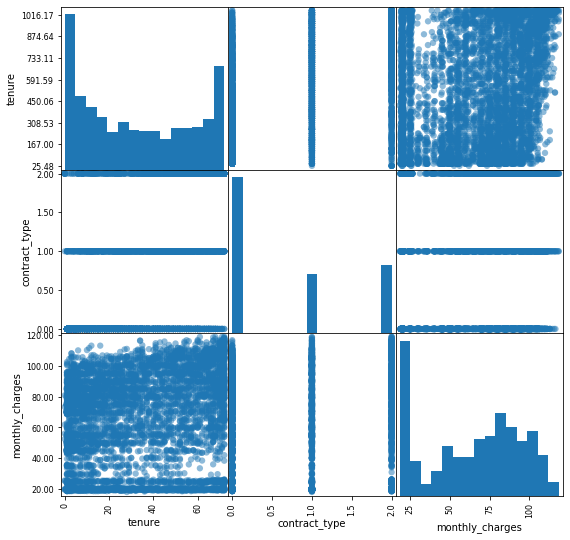

In [41]:
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

cmap = cm.get_cmap('gnuplot')
axes = pd.plotting.scatter_matrix(
    train[['tenure', 'contract_type', 'monthly_charges']], marker='o', s=40,
    hist_kwds={'bins':15},  figsize=(9,9), cmap=cmap)
for ax in axes.flatten():
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


# axes = pd.plotting.scatter_matrix(df, alpha=0.3, figsize=(9,9), diagonal='kde')
# for ax in axes.flatten():
#    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 

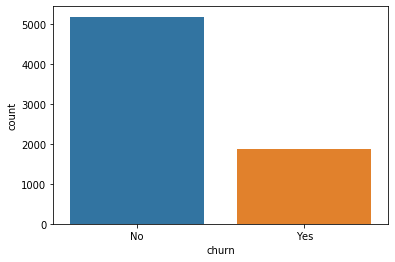

In [42]:
sns.countplot(x='churn', data=dfstart)

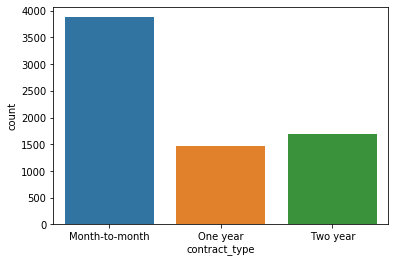

In [43]:
sns.countplot(x='contract_type', data=dfstart)
#plt.xlabel(0:'Month to month', 1:"1year", 2:"2year" )

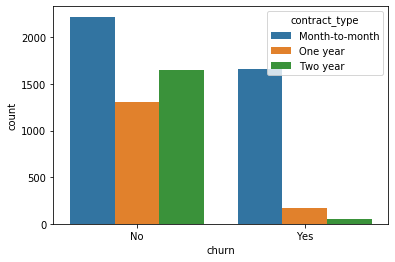

In [44]:
#distribution of contract types and whether customer churned 
sns.countplot(x='churn', data=dfstart, hue='contract_type')


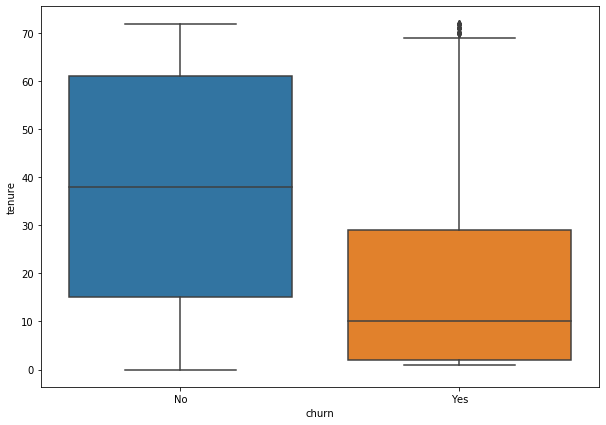

In [45]:

#Boxplot to show the distribution of ages. X is class, Y is age.
plt.figure(figsize = (10,7))
sns.boxplot(x='churn', y='tenure', data=dfstart)

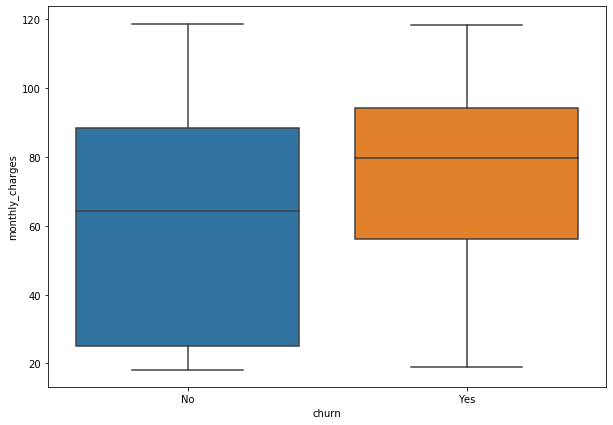

In [46]:
plt.figure(figsize = (10,7))
sns.boxplot(x='churn', y='monthly_charges', data=dfstart)

## Train Model
### Creating a baseline with a decision tree



In [47]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=123)

#### Fit the model to the training data



In [48]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

#### Estimate Churn



In [49]:
y_pred = clf.predict(X_train)
y_pred[0:100]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Estimate the probability customer churn

y_pred_proba = clf.predict_proba(X_train)
y_pred_proba

## Evaluate Model

### Compute the Accuracy

### Accuracy: number of correct predictions over the number of total instances that have been evaluated.

In [50]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.79


### Create a confusion matrix

#### True Positive: number of occurrences where y is true and y is predicted true.
#### True Negative: number of occurrences where y is false and y is predicted false.
#### False Positive: number of occurrences where y is false and y is predicted true.
#### False Negative: number of occurrences where y is true and y is predicted false.

In [51]:
confusion_matrix(y_train, y_pred)

array([[3334,  297],
       [ 762,  537]])

In [52]:
sorted(y_train.churn.unique())

[0, 1]

In [53]:
y_train.churn.value_counts()

0    3631
1    1299
Name: churn, dtype: int64

In [54]:
import pandas as pd

labels = sorted(y_train.churn.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,3334,297
1,762,537


### Create a classification report

In [55]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      3631
           1       0.64      0.41      0.50      1299

    accuracy                           0.79      4930
   macro avg       0.73      0.67      0.68      4930
weighted avg       0.77      0.79      0.77      4930



### Test Model

##### Compute the accuracy of the model when run on the test data

In [56]:
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.78


In [57]:
dot_data = export_graphviz(clf, out_file=None) 
graph = Source(dot_data) 

graph.render('telco_decision_tree', view=True)

'telco_decision_tree.pdf'

## Creating a CSV for the decision tree results

df_final = pd.concat(['customer_id',X_train, X_test])
df_final.shape

prediction = clf.predict(df_final)
# y_pred[0:50]
y_pred_proba = clf.predict_proba(df_final)
# y_pred_proba[:,1]
y_predictions = pd.DataFrame({'probability': y_pred_proba[:,1], 'predictions': (y_pred_proba[:,1] >= .5) == 1})
y_predictions = y_predictions.set_index(df.index)
y_predictions.to_csv(r'predictions.csv')

# MVP
Because the majority of churn (55%) are customers that are on month to month contracts, Isolating this group and examining all the features affect on the churn rate will be the basis of my minimum variable product.

### Acquire and Clean- imported a table with only month to month customers.

In [163]:
dfmv= acquire.prep_telco_month()

In [164]:
dfmvp=pd.DataFrame(dfmv)

In [165]:
dfmvp= dfmvp.drop (dfmvp[['customer_id','internet_service_type_id', 'payment_type_id', 'contract_type_id', 'payment_type_id']], axis=1)

In [166]:
dfmvp= dfmvp.drop (dfmvp[[ 'multiple_lines', 'online_backup', 'payment_type', 'internet_service_type', 'contract_type']], axis=1)

In [167]:
dfmvp['partner'] = dfmvp['partner'].replace({'Yes':1,'No':0})
dfmvp['dependents'] = dfmvp['dependents'].replace({'Yes':1,'No':0})
dfmvp['phone_service']= dfmvp ['phone_service'].replace({'Yes':1,'No':0})
dfmvp['online_security']= dfmvp['online_security'].replace({'Yes':1,'No':0,'No internet service':2})
dfmvp['device_protection']= dfmvp['device_protection'].replace({'Yes':1,'No':0,'No internet service':2})
dfmvp['tech_support']= dfmvp['tech_support'].replace({'Yes':1,'No':0,'No internet service':2})
dfmvp['streaming_tv']= dfmvp['streaming_tv'].replace({'Yes':1,'No':0,'No internet service':2})
dfmvp['streaming_movies']= dfmvp['streaming_movies'].replace({'Yes':1,'No':0,'No internet service':2})
dfmvp['paperless_billing']=dfmvp['paperless_billing'].replace({'Yes':1,'No':0})
dfmvp['gender']= dfmvp['gender'].replace({'Male':1,'Female':0})
dfmvp['churn']=dfmvp['churn'].replace({'Yes':1, 'No':0})

Graphs

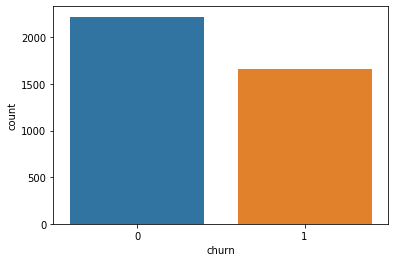

In [168]:
sns.countplot(x='churn', data=dfmvp)

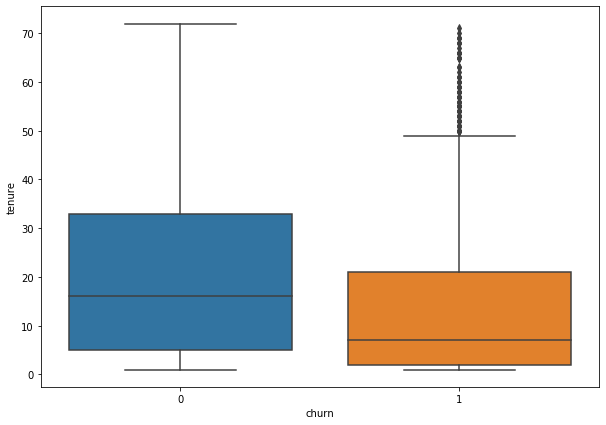

In [169]:
plt.figure(figsize = (10,7))
sns.boxplot(x='churn', y='tenure', data=dfmvp)

In [170]:
train2, test2= split_scale.split_my_data(dfmvp, train_ratio=0.8, seed=123)

In [171]:
X2 = dfmvp[['gender','senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service', 'online_security', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'monthly_charges', 'total_charges',
    ]]
y2 = dfmvp[['churn']]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = .30, random_state = 123)

X_train2.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,online_security,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges
3547,1,0,0,0,22,1,0,0,0,1,1,1,94.65,2104.55
645,1,1,1,0,60,1,0,0,1,1,1,1,99.00,6017.9
723,0,0,1,1,14,1,0,1,0,0,1,1,87.25,1258.6
3556,0,1,0,0,11,1,0,0,0,0,1,1,84.80,906.85
2238,0,1,0,0,19,1,1,0,1,1,1,1,105.00,2007.25


#### Create the Decision Tree Object

In [172]:
clf2 = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)

#### Fit the model to the training data


In [173]:
clf2.fit(X_train2, y_train2)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

#### Estimate churn


In [174]:
y_pred2 = clf2.predict(X_train2)
y_pred2[0:100]

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0])

#### Estimate the probability of a species

In [175]:
y_pred_proba2 = clf2.predict_proba(X_train2)
y_pred_proba2

array([[0.52546584, 0.47453416],
       [0.52546584, 0.47453416],
       [0.52546584, 0.47453416],
       ...,
       [0.52546584, 0.47453416],
       [0.20766773, 0.79233227],
       [0.52546584, 0.47453416]])

### Evaluate Model

#### Compute the Accuracy

Accuracy: number of correct predictions over the number of total instances that have been evaluated.

In [176]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf2.score(X_train2, y_train2)))

Accuracy of Decision Tree classifier on training set: 0.67


### Test Model

Compute the accuracy of the model when run on the test dataTest Model


In [177]:
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf2.score(X_test2, y_test2)))

Accuracy of Decision Tree classifier on test set: 0.64


### In order to isolate the features that had the biggest impact on this decison tree mode ran a feature importance 

In [178]:
list_X = list(X_train2.columns)

In [179]:
MVP_tree_scores = dict(zip(list_X,clf2.feature_importances_))
MVP_tree_scores

{'gender': 0.0,
 'senior_citizen': 0.0,
 'partner': 0.0,
 'dependents': 0.0,
 'tenure': 0.29794458656642886,
 'phone_service': 0.0,
 'online_security': 0.3653094693310959,
 'device_protection': 0.0,
 'tech_support': 0.0,
 'streaming_tv': 0.0,
 'streaming_movies': 0.0,
 'paperless_billing': 0.0,
 'monthly_charges': 0.27281206982676615,
 'total_charges': 0.06393387427570918}

#### The most important dfeatures within the month to month customer base that affect4ed churn was: tenure, online_secuirty, tech_support, monthly _charges, and Total_charges

##### Variables used in MVP Calculation:
tenure
online_secuirty
tech_support
monthly _charges
total_charges

## Logistic Regression
To imporve upon the MVP, I used the same dataframe and applied that to a logistic regression model.

In [180]:
X3 = df[['gender','senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service', 'online_security', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'monthly_charges', 'total_charges',
    ]]
y3 = df[['churn']]

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = .30, random_state = 123)



In [181]:
df.head(1)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,online_security,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type
0,0003-MKNFE,1,0,0,0,9,1,0,0,0,0,1,0,59.9,542.4,0,0


In [182]:
dfmvp.head(1)

,gender,senior_citizen,partner,dependents,tenure,phone_service,online_security,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn
0,0,1,0,0,7,1,1,0,0,0,0,1,48.2,340.35,0


#### Create the logistic regression object


In [183]:
logit = LogisticRegression(C=1, class_weight={1:2}, random_state = 123, solver='saga')

#### Fit the model to the training data


In [184]:
logit.fit(X_train3, y_train3)

LogisticRegression(C=1, class_weight={1: 2}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [185]:
#Print the coefficients and intercept of the model

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-0.00029599  0.00034558 -0.00041937 -0.00064478 -0.02751851 -0.00057114
  -0.00212654 -0.00172416 -0.00209518 -0.00145422 -0.00141806  0.00033154
   0.01450475 -0.00017265]]
Intercept: 
 [-0.00067291]


#### Estimate whether or not a customer will churn, using the training data



In [186]:
y_pred3 = logit.predict(X_train3)

### Estimate the probability of a passenger surviving, using the training data



In [187]:
y_pred_proba3 = logit.predict_proba(X_train3)

### Evaluate Model

#### Compute the accuracy



In [188]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train3, y_train3)))

Accuracy of Logistic Regression classifier on training set: 0.70


##### Since the logistic regresion model only produced a rate of 70%, this will be ignored

## KNN

##### Becauxse going furthur with just isolating the contract type did not imporve the model (see Decision tree- Month to month and logistic regression-month to month. I decided to use the KNN method with the baseline data.

In [298]:
X4 = df[['tenure','tech_support', 'monthly_charges', 'total_charges',]]
y4 = df[['churn']]

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size = .10, random_state = 123)


### Train Model

#### Create KNN Object
##### weights = ['uniform', 'density']



In [299]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

#### Fit the model to the training data


In [300]:
knn.fit(X_train4, y_train4)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

#### Estimate whether or not a customer will churn, using the training data

In [301]:
y_pred4 = knn.predict(X_train4)

#### Estimate the probability of a passenger surviving, using the training data


In [302]:
y_pred_proba4 = knn.predict_proba(X_train4)

#### Evaluate Model

#### Compute the accuracy



In [303]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train4, y_train4)))

Accuracy of KNN classifier on training set: 0.83


##### Because this model with the training data is above my MVP of 79%, I will go furthur and evaluate the model with the test data

#### Create a confusion matrix

In [304]:
print(confusion_matrix(y_train4, y_pred4))

[[4298  358]
 [ 738  944]]


In [305]:
#Compute Precision, Recall, F1-score, and Support

print(classification_report(y_train4, y_pred4))

              precision    recall  f1-score   support

           0       0.85      0.92      0.89      4656
           1       0.73      0.56      0.63      1682

    accuracy                           0.83      6338
   macro avg       0.79      0.74      0.76      6338
weighted avg       0.82      0.83      0.82      6338



### Test Model

#### Compute the accuracy of the model when run on the test data


In [306]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test4, y_test4)))

Accuracy of KNN classifier on test set: 0.79


#### By adding tech support along with the baseline features I was able toi improve the model to 79%

# EXPORE

## 1: Could the month in which they signed up influence churn? i.e. if a cohort is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts? (Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers)

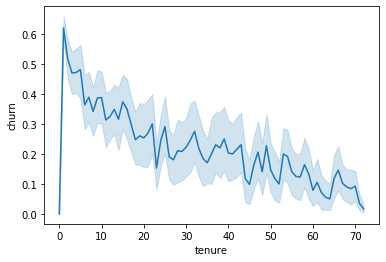

In [92]:
sns.lineplot(x="tenure", y='churn', data=df)
plt.show()

"Customers" are more of prospects when they are under month to month contract, especially in the first six months. 
It is inconclusive on whether there is a specific month where churn will occur, but we can conlcude the first 8 months is 
time period where churn most occurs in this customer base.

## 2:Are there features that indicate a higher propensity to churn? like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?

In [93]:
meanmc= df['monthly_charges'].mean()

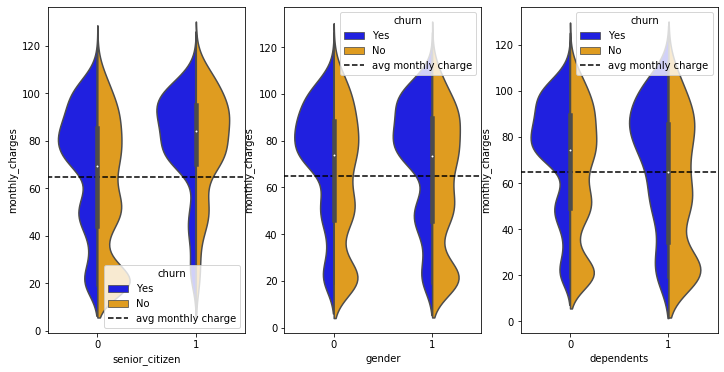

In [94]:
# 3. violin plot
features = ['senior_citizen', 'gender', 'dependents']
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,6))


for i, feature in enumerate(features):
    ax[i].hlines(meanmc,-1,2, label= "avg monthly charge", ls= "--", color= 'black')
    sns.violinplot(feature, 'monthly_charges', hue='churn',
        data=train2, split=True, ax=ax[i], palette=['blue','orange'])


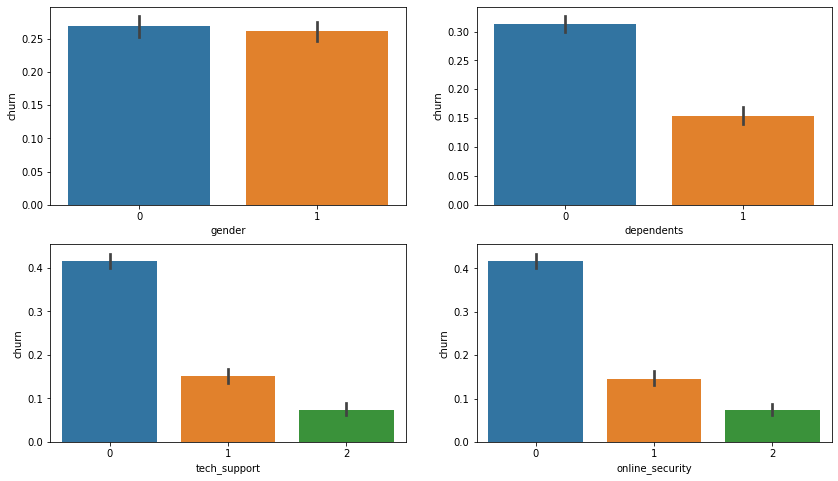

In [104]:
plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
sns.barplot(x="gender", y="churn", data=df)

plt.subplot(2,2,2)
sns.barplot(x="dependents", y="churn", data=df)

plt.subplot(2,2,1)
sns.barplot(x="tech_support", y="churn", data=df)

#plt.subplot(2,2,4)
#sns.barplot(x="senior_citizen", y="churn", data=df)

#tenure online_secuirty tech_support monthly _charges total_charges
plt.subplot(2,2,4)
sns.barplot(x='online_security', y='churn', data= df)

## 3. Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?

In [96]:
dfmvp.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,online_security,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn
0,0,1,0,0,7,1,1,0,0,0,0,1,48.20,340.35,No
1,1,1,0,0,1,0,0,0,0,0,0,1,25.10,25.1,Yes
2,1,1,0,0,2,1,1,0,0,0,0,1,49.25,91.1,Yes
3,0,0,1,0,6,1,0,0,0,0,0,0,50.35,314.55,No
4,1,0,1,0,22,1,1,0,1,0,0,1,54.20,1152.7,Yes


### 4.If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

In [97]:
df1year= acquire.prep_telco_1year()


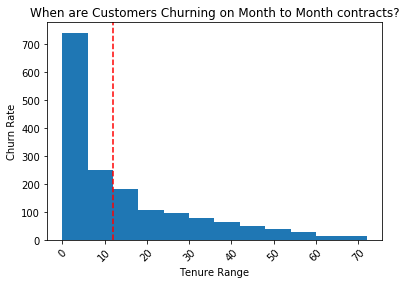

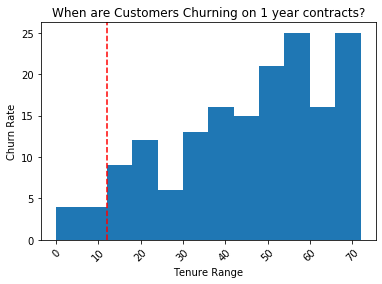

In [98]:
#Month to Month vs one year Contracts
bins = [0,6,12,18,24,30,36,42,48,54,60,66,72]
plt.hist('tenure', data = dfmvp[dfmvp.churn == 'Yes'], alpha = 1, bins = bins)

plt.ylabel('Churn Rate')
plt.xlabel('Tenure Range')
plt.xticks(rotation = 45)
plt.title('When are Customers Churning on Month to Month contracts?')
plt.axvline(x=12, ls='--', color='red')
plt.show()


bins = [0,6,12,18,24,30,36,42,48,54,60,66,72]
plt.hist('tenure', data = df1year[df1year.churn == 'Yes'], alpha = 1, bins = bins)

plt.ylabel('Churn Rate')
plt.xlabel('Tenure Range')
plt.xticks(rotation = 45)
plt.title('When are Customers Churning on 1 year contracts?')
plt.axvline(x=12, ls='--', color='red')
plt.show()



The rate of churn are not comparable, the churn rate for Mopnth to Mopnth contracts decreases dramatically after month 12 while the exact opposite hold true for one year contracts.

## Creating a CSV for the decision tree results


In [ ]:
df_final = pd.concat([numeric_X_train, numeric_X_test])
df_final.shape
prediction = clf.predict(df_final)
# y_pred[0:50]
y_pred_proba = clf.predict_proba(df_final)
# y_pred_proba[:,1]
y_predictions = pd.DataFrame({'probability': y_pred_proba[:,1], 'predictions': (y_pred_proba[:,1] >= .5) == 1})
y_predictions = y_predictions.set_index(df.index)
y_predictions.to_csv(r'DT_probability_and_predictions.csv')

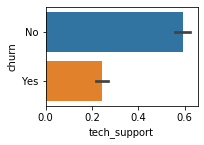

In [ ]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()